# Comparison of Isomap versions on small dataset (diabetes)
### (neighbors from sklearn vs neighbors from pynndescent)

In [1]:
import sys
sys.path.append('../')

In [2]:
from typing import Union, Callable, Optional
import warnings
import torch
import torch.nn.functional as F
import pynndescent
from scipy.spatial import distance
import paradime

from paradime import relationdata
from paradime import relations
from paradime import transforms
from paradime import dr
from paradime.types import BinaryTensorFun, TensorLike
Transform = Union[transforms.RelationTransform, list[transforms.RelationTransform]]
from paradime import utils

from matplotlib import pyplot as plt
import numpy as np
import sklearn.datasets

In [3]:
# set a seed
paradime.utils.seed.seed_all(42);

### Data

In [4]:
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']
data.shape

(442, 10)

In [5]:
# isomap with neighbours from sklearn
paradime.utils.seed.seed_all(42);

def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=paradime.relations.GeodesicDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap.train(data)

2023-02-06 22:09:24,062: Initializing training dataset.
2023-02-06 22:09:24,064: Computing global relations 'rel'.
2023-02-06 22:09:24,065: Calculating geodesic distances.
2023-02-06 22:09:24,176: Beginning training phase 'None'.
2023-02-06 22:09:24,198: Loss after epoch 0: 30821.27734375
2023-02-06 22:09:24,903: Loss after epoch 50: 10180.4814453125
2023-02-06 22:09:25,580: Loss after epoch 100: 7533.1337890625
2023-02-06 22:09:26,262: Loss after epoch 150: 6165.900390625
2023-02-06 22:09:27,004: Loss after epoch 200: 5148.6083984375
2023-02-06 22:09:27,681: Loss after epoch 250: 4497.4794921875
2023-02-06 22:09:28,370: Loss after epoch 300: 3899.44384765625
2023-02-06 22:09:29,058: Loss after epoch 350: 3269.91796875
2023-02-06 22:09:29,775: Loss after epoch 400: 2740.239013671875
2023-02-06 22:09:30,510: Loss after epoch 450: 2407.80419921875


In [6]:
# for isomap with neighbours from pynndescent
paradime.utils.seed.seed_all(42);

def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap_new = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=paradime.relations.GeodesicDistNew(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap_new.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap_new.train(data)

2023-02-06 22:09:31,243: Initializing training dataset.
2023-02-06 22:09:31,244: Computing global relations 'rel'.
2023-02-06 22:09:31,246: Calculating geodesic distances.
2023-02-06 22:09:57,538: Beginning training phase 'None'.
2023-02-06 22:09:57,599: Loss after epoch 0: 32366.90625
2023-02-06 22:09:58,413: Loss after epoch 50: 10945.0205078125
2023-02-06 22:09:59,337: Loss after epoch 100: 8087.529296875
2023-02-06 22:10:00,205: Loss after epoch 150: 6757.24658203125
2023-02-06 22:10:01,093: Loss after epoch 200: 5793.8359375
2023-02-06 22:10:01,948: Loss after epoch 250: 5223.5400390625
2023-02-06 22:10:02,870: Loss after epoch 300: 4743.1923828125
2023-02-06 22:10:03,717: Loss after epoch 350: 4185.0732421875
2023-02-06 22:10:04,551: Loss after epoch 400: 3559.072998046875
2023-02-06 22:10:05,503: Loss after epoch 450: 3002.9033203125


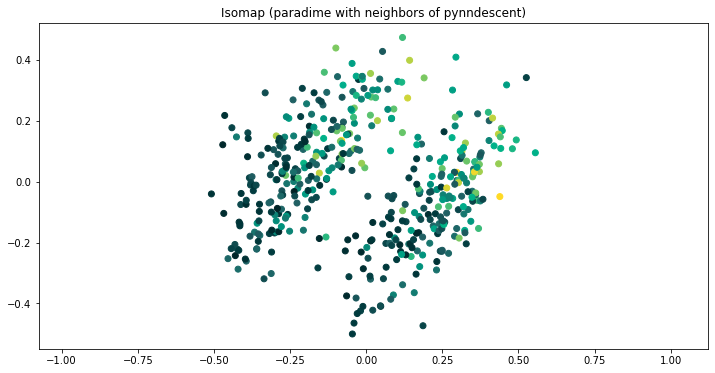

In [7]:
isomap_matrix_new = pd_isomap_new.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix_new, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime with neighbors of pynndescent)");

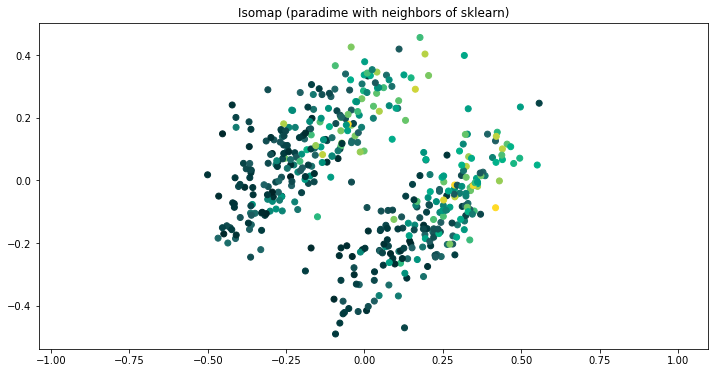

In [8]:
isomap_matrix = pd_isomap.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.axis('equal')
ax.set_title("Isomap (paradime with neighbors of sklearn)");

## Compare with the Isomap of sklearn

In [9]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(data)

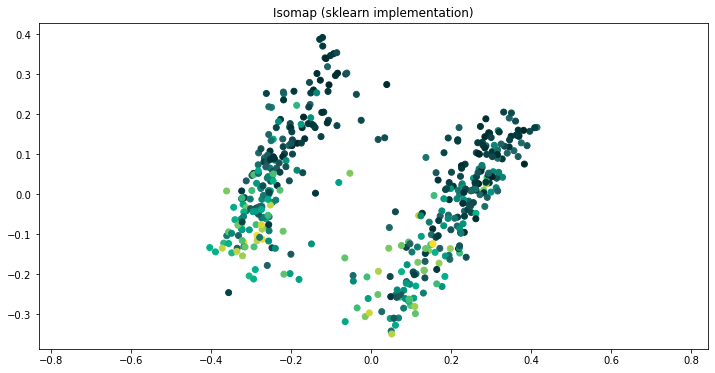

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=diabetes.target, cmap=paradime.utils.plotting.get_colormap())
plt.title("Isomap (sklearn implementation)")
plt.axis('equal')
plt.show()

## Interpretation and comparison:
On this small example we can see that the isomap with the neighbours of sklearn took 7.2 seconds, while the new version with the neighbors from pynndescent took 7.7 seconds. Both results are very similar to the one of the original isomap of sklearn.

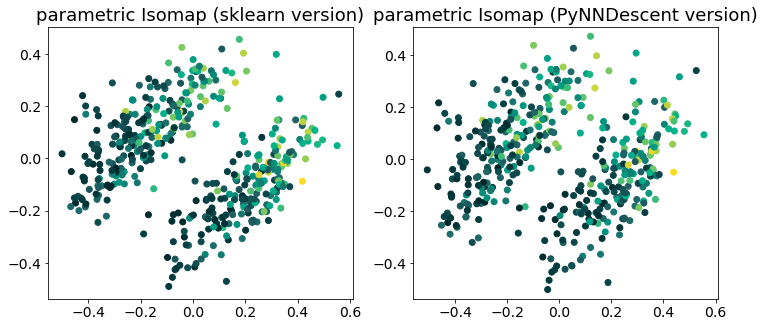

In [11]:
cmap = paradime.utils.plotting.get_colormap()
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)

ax2.scatter(
    *np.stack([np.dot(isomap_matrix_new, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)


ax1.axis('equal')
ax1.set_title("parametric Isomap (sklearn version)");
ax2.axis('equal')
ax2.set_title("parametric Isomap (PyNNDescent version)");

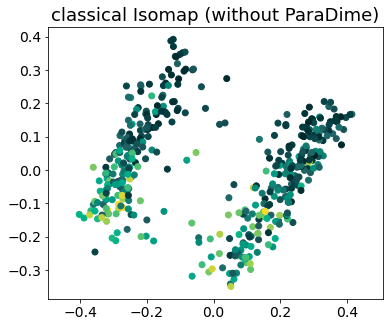

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

ax1.scatter(X_transformed[:, 0], X_transformed[:, 1], c=diabetes.target, cmap=paradime.utils.plotting.get_colormap())
ax1.set_title("classical Isomap (without ParaDime)");
ax1.axis('equal');
